In [1]:
import os.path

import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
import sys
from pytorch_lightning import seed_everything
seed_everything(123)

2023-07-12 19:40:07.430974: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Global seed set to 123


123

In [2]:
transform = transforms.Compose(
    # [transforms.Resize((224,224)),
     [transforms.RandomCrop(32, padding = 4),
     transforms.RandomHorizontalFlip(p = 0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.485,0.456, 0.406), (0.229,0.224, 0.225))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 3, 32, 32])


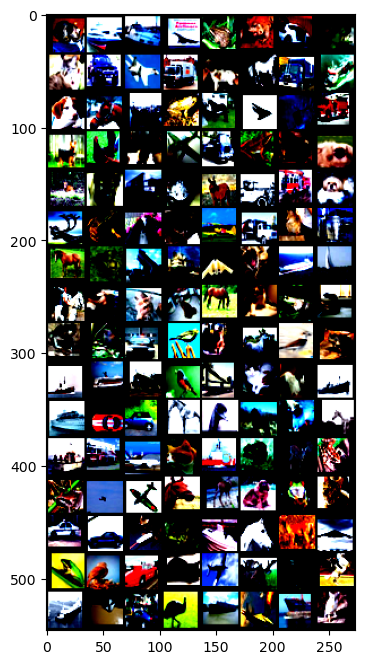

In [3]:
plt.figure(figsize=(8, 8))
iter_dataloader = iter(test_dataloader)

n=1

# 取出n*batch_size张图片可视化
for i in range(n):
    images, labels = next(iter_dataloader)
    print(images.shape)
    image_grid = torchvision.utils.make_grid(images)
    plt.subplot(1, n, i+1)
    plt.imshow(np.transpose(image_grid.numpy(), (1, 2, 0)))

In [4]:
# class LeNet(nn.Module):
#     def __init__(self, dropout_scale_train = 0, dropout_scale_test = 0):
#         super(LeNet,self).__init__()
#         # self.dropout_scale = dropout_scale
#         self.conv = nn.Sequential(
#             nn.Conv2d(1,6,3,stride=1,padding=1),
#             nn.MaxPool2d(2,2),
#             nn.Conv2d(6,16,5,stride=1,padding=1),
#             # nn.Dropout2d(p = dropout_scale),
#             nn.MaxPool2d(2,2)
#         )
#         self.train_dropout = nn.Dropout(p=dropout_scale_train)
#         self.test_dropout = nn.Dropout(p=dropout_scale_test)
#         self.fc = nn.Sequential(
#             nn.Linear(576,120),
#             nn.ReLU(),
#             nn.Linear(120,84),
#             nn.ReLU(),
#             nn.Linear(84,10)
#         )
#     def forward(self,x, test = False):
#         out = self.conv(x)
#         out = out.view(out.size(0),-1)
#         if test:
#             out = self.test_dropout(out)
#         else: 
#             out = self.train_dropout(out)
#         out = self.fc(out)
#         return out
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        # self.dropout_scale = dropout_scale
        self.conv = nn.Sequential(
            nn.Conv2d(3,64,3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(64,64,3,stride=1,padding=1),
            nn.ReLU(),
            # nn.Dropout2d(p = dropout_scale),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64,128,3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(128,128,3,stride=1,padding=1),
            nn.ReLU(),
            # nn.Dropout2d(p = dropout_scale),
            nn.MaxPool2d(2,2)
        )
        # self.train_dropout = nn.Dropout(p=dropout_scale_train)
        # self.test_dropout = nn.Dropout(p=dropout_scale_test)
        self.fc = nn.Sequential(
            nn.Linear(8192,200),
            nn.ReLU(),
            nn.Linear(200,10),
        )
    def forward(self,x, rate = 0):
        out = self.conv(x)
        out = out.view(out.size(0),-1)
        out = F.dropout(out, p=rate)
        # if test:
        #     out = self.test_dropout(out)
        # else: 
        #     out = self.train_dropout(out)
        out = self.fc(out)
        return out

In [5]:
device = 'cuda:2' if torch.cuda.is_available() else 'cpu'
def train(network, dropout_scale = 0):
    network.train()
    losses = []
    iteration = 0
    epochs = 40
    for epoch in range(epochs):
        loss_sum = 0
        for i, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)

            pred = network(X, rate = dropout_scale)
            loss = loss_fn(pred, y)

            loss_sum += loss.item()

            optimizer.zero_grad()
            loss.backward() 
            optimizer.step()
        schduler.step()
        mean_loss = loss_sum / (i +1)
        losses.append(mean_loss)
        iteration += 1
        print(f"Epoch {epoch+1} loss: {mean_loss:>7f}")

    # 训练完毕保存最后一轮训练的模型
    torch.save(network.state_dict(), "model.pth")



In [6]:
def test(network, dropout_scale = 0):
    positive = 0
    total = 0
    network.train()
    for X, y in test_dataloader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            # pred_list = []
            total += y.size(0)
            # for j in range(100):
            pred = network(X, rate = dropout_scale)
            pred = F.softmax(pred, dim = 1)
            _, predicted = torch.max(pred.data, 1)
            positive += (predicted == y.to(device)).sum().item()
    acc = positive / total
    print(f"{acc * 100}%")
    return acc
# network = LeNet()
# network.to(device)
# test(network)

Epoch 1 loss: 1.818570
Epoch 2 loss: 1.489798
Epoch 3 loss: 1.311750
Epoch 4 loss: 1.261406
Epoch 5 loss: 1.216873
Epoch 6 loss: 0.997365
Epoch 7 loss: 0.908801
Epoch 8 loss: 0.861292
Epoch 9 loss: 0.829426
Epoch 10 loss: 0.796021
Epoch 11 loss: 0.676606
Epoch 12 loss: 0.648092
Epoch 13 loss: 0.612538
Epoch 14 loss: 0.595435
Epoch 15 loss: 0.580892
Epoch 16 loss: 0.521331
Epoch 17 loss: 0.500748
Epoch 18 loss: 0.486025
Epoch 19 loss: 0.467866
Epoch 20 loss: 0.462596
Epoch 21 loss: 0.432145
Epoch 22 loss: 0.413522
Epoch 23 loss: 0.404523
Epoch 24 loss: 0.402528
Epoch 25 loss: 0.394073
Epoch 26 loss: 0.376723
Epoch 27 loss: 0.371853
Epoch 28 loss: 0.365698
Epoch 29 loss: 0.363849
Epoch 30 loss: 0.357497
Epoch 31 loss: 0.347700
Epoch 32 loss: 0.346874
Epoch 33 loss: 0.345764
Epoch 34 loss: 0.340053
Epoch 35 loss: 0.335812
Epoch 36 loss: 0.338788
Epoch 37 loss: 0.336476
Epoch 38 loss: 0.337663
Epoch 39 loss: 0.333534
Epoch 40 loss: 0.330663
======dropout_train= 0 , dropout_test= 0 =======


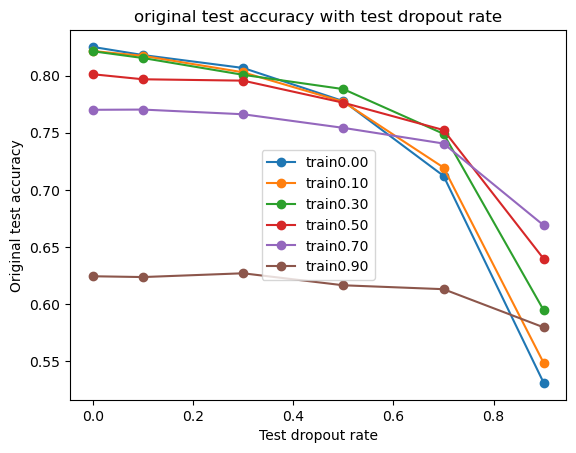

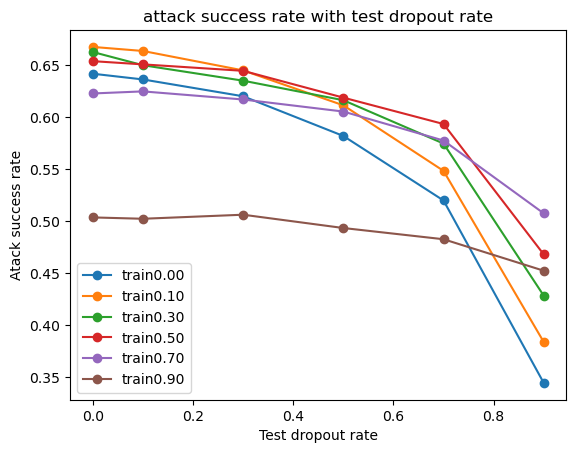

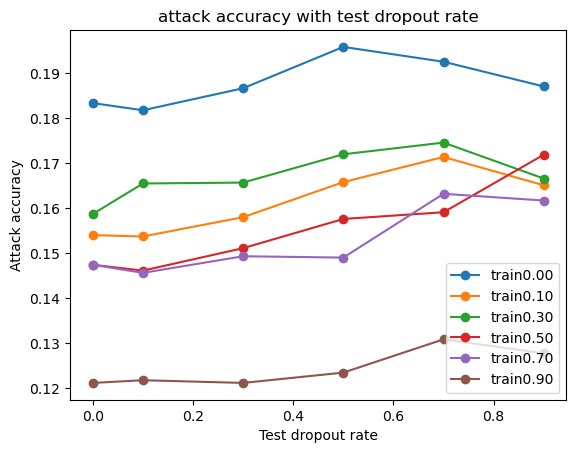

In [7]:
eps = [0, 0.1, 0.3, 0.5, 0.7, 0.9]


loss_fn = nn.CrossEntropyLoss()

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
for I in eps:
    acc_list = []
    acc_adv_list = []
    success_rate_list = []
    network = LeNet()
    network.to(device)
    optimizer = torch.optim.SGD(params=network.parameters(), lr=0.1, momentum=0.9)
    schduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [5,10,15,20,25,30], gamma=0.5)
    train(network, dropout_scale=I)
    for J in eps:
        print(f"======dropout_train= {I} , dropout_test= {J} =======")
        acc_org = test(network, dropout_scale=J)
        acc_list.append(acc_org)
        # 用对抗样本替代原始样本，测试准确度
        # 探究不同epsilon对LeNet分类准确度的影响
        positive = 0
        negative = 0
        # for epsilon in eps:
        epsilon = 0.25
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            X.requires_grad = True
            pred = network(X, rate = J)
            network.zero_grad()
            loss = loss_fn(pred, y)
            loss.backward()
            X = X + epsilon * X.grad.sign()
            X_adv = torch.clamp(X, 0, 1)

            pred = network(X_adv, rate = J)
            pred = F.softmax(pred, dim = 1)
            for item in zip(pred, y):
                if torch.argmax(item[0]) == item[1]:
                    positive += 1
                else:
                    negative += 1

        acc_adv = positive / (positive + negative)
        acc_adv_list.append(acc_adv)
        attack_success_rate = acc_org - acc_adv
        success_rate_list.append(attack_success_rate)
        print(f"epsilon={epsilon} acc_org: {acc_org * 100}%  acc_adv: {acc_adv * 100}%  attack success rate:  {attack_success_rate * 100}%")
        print(f"acc_org: {acc_org * 100}%" )
    ax1.plot(eps, acc_list, 'o-',label = 'train%.2f'%I)
    ax2.plot(eps, success_rate_list, 'o-',label = 'train%.2f'%I)
    ax3.plot(eps, acc_adv_list, 'o-',label = 'train%.2f'%I)
ax1.set_xlabel("Test dropout rate")
ax1.set_ylabel("Original test accuracy")
ax1.set_title('original test accuracy with test dropout rate')
ax1.legend()
ax2.set_xlabel("Test dropout rate")
ax2.set_ylabel("Atack success rate")
ax2.set_title('attack success rate with test dropout rate')
ax2.legend()
ax3.set_xlabel("Test dropout rate")
ax3.set_ylabel("Attack accuracy")
ax3.set_title('attack accuracy with test dropout rate')
ax3.legend()
plt.show()